# Neu 501a
## Topic: Population Coding

### Problem 1a
Simulate a population of 21 independent Poisson neurons with Gaussian-shaped tuning curves $f_i(x)$ that have an amplitude of 15 and a standard deviation $\sigma_i$ = 1, with centers $\mu_i$ evenly spaced between -10 and +10 on the x axis. That is, let tuning curve of the i-th neuron be: 

> $f_i(x) = 15 \cdot exp(-\frac{(x-\mu_i)^2}{2\sigma^2_i})$

Plot all the tuning curves on one axis. 

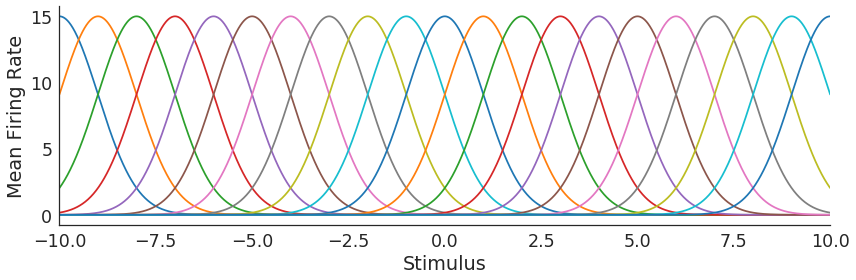

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define paramters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Tuning curve parameters.
S = np.linspace(-10,10,21) # Stimulus preferences.
sd = 1                     # Width
A = 15                     # Amplitude

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate tuning curves.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def gaussian_curve(x, mu=0, sd=1, A=1):
    return A * np.exp(-np.power(x-mu,2)/(2*sd**2) )

## Define stimulus continuum. 
x = np.arange(S.min(), S.max() + 1e-2, 1e-2).round(2)

## Simulate tuning curves.
tuning_curves = np.array([gaussian_curve(x, s, sd=sd, A=A) for s in S])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot tuning curves.
ax.plot(x, tuning_curves.T)
ax.set(xlim=(x.min(), x.max()), xlabel='Stimulus', ylabel='Mean Firing Rate')

sns.despine()
plt.tight_layout()

### Problem 1b
Simulate the population response to the stimulus x = −1 and plot the population response as a function of each neuron’s preferred orientation.

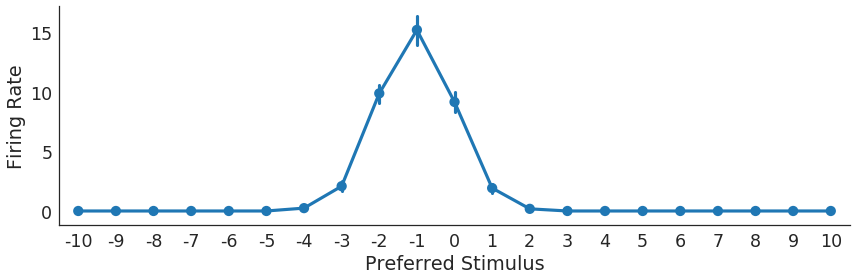

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate population response.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define number of simulations.
n_sim = 50

## Simulate spikes.
spikes = np.array([np.random.poisson(gaussian_curve(-1, s, sd=sd, A=A), n_sim) for s in S])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
sns.pointplot(data=spikes.T, ci=95, ax=ax)
ax.set(xticklabels=S.astype(int), xlabel='Preferred Stimulus', ylabel='Firing Rate')

sns.despine()
plt.tight_layout()

### Problem 2
Write functions to perform winner-take-all decoding, center-of-mass decoding, template-matching decoding, maximum-likelihood, and maximum *a posteriori* (MAP) decoding given a vector of neural responses, $r$.

#### Winner-Take-All

In [3]:
def winner_take_all(s, r):
    return s[np.argmax(r)]

#### Center-of-Mass

In [4]:
def center_of_mass(s, r):
    return np.inner(s,r) / np.sum(r)

#### Template-Matching

In [5]:
from scipy.optimize import minimize

def gaussian_curve_fixed(x, mu):
    return 15 * np.exp(-np.power(x-mu,2)/(2*1**2) )

def template_matching(s, r, x0=0):
    f = lambda s_hat, S, R: np.power( gaussian_curve_fixed(S, s_hat) - R, 2 ).sum()
    result = minimize(f, x0=0, args=(s, r), bounds=((-7.5, 7.5),))
    return result.x[0]

#### Maximum Likelihood

In [6]:
from scipy.stats import poisson

def poisson_loglik(s_hat, S, R):
    Rhat = gaussian_curve_fixed(S, s_hat)
    return -np.log( [poisson(rh).pmf(r) for r, rh in zip(R, Rhat)] ).sum()

def maximum_likelihood(s, r, x0=0):
    result = minimize(poisson_loglik, x0=0, args=(s, r))
    return result.x[0]

#### Maximum A Posteriori 

In [7]:
from scipy.stats import uniform, norm

def uniform_prior(s_hat):
    '''Paramerization: [loc, loc+scale]'''
    return -np.log( uniform(-10,20).pdf(s_hat) )

def normal_prior(s_hat):
    return -np.log( norm(0,3).pdf(s_hat) )

def maximum_a_posteriori(s, r, prior, x0=0):
    f = lambda s_hat, S, R: prior(s_hat) + poisson_loglik(s_hat, S, R)
    result = minimize(f, x0=0, args=(s, r))
    return result.x[0]

### Problem 3a
Perform a simulated experiment consisting of 100 repetitions of the following: draw x from a Gaussian with mean 0 and standard deviation 3. Simulate the population response, $r$, and compute the stimulus estimate using each of the decoders listed above. 

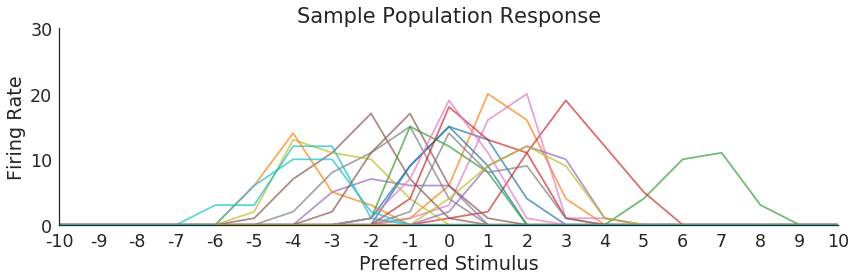

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate population responses.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(8002)

## Define paramters.
n_sim = 100

## Draw X randomly.
X = np.random.normal(0, 3, n_sim)

## Prealloate space.
R = np.zeros((X.size, S.size))

## Simulate population response.
for n, x in enumerate(X):
    R[n] = [np.random.poisson(gaussian_curve(x, s, sd=sd, A=A), 1) for s in S]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(S, R[::5].T, alpha=0.7)
ax.set(xlim=(S.min(), S.max()), xticks=S, xticklabels=S.astype(int), ylim=(0,30),
       xlabel='Preferred Stimulus', ylabel='Firing Rate', title='Sample Population Response')

sns.despine()
plt.tight_layout()

### Problem 3b
Make a bar graph showing the average error for each of the decoders.

In [9]:
import warnings
warnings.filterwarnings("ignore")

## Preallocate space.
error = np.zeros((n_sim, 6))

## Compute errors.
for n, r in enumerate(R):
    
    ## Preallocate space.
    S_hat = np.zeros(6)
    
    ## Winner-take-all.
    S_hat[0] = winner_take_all(S, r)
    
    ## Center-of-mass.
    S_hat[1] = center_of_mass(S, r)
    
    ## Template-matching.
    S_hat[2] = template_matching(S, r)
        
    ## Maximum likelihood,
    S_hat[3] = maximum_likelihood(S, r)
    
    ## Maximum a posteriori (uniform).
    S_hat[4] = maximum_a_posteriori(S, r, uniform_prior)
    
    ## Maximum a posteriori (normal).
    S_hat[5] = maximum_a_posteriori(S, r, normal_prior)
    
    ## Store error.
    error[n] = np.power(S_hat - X[n], 2)

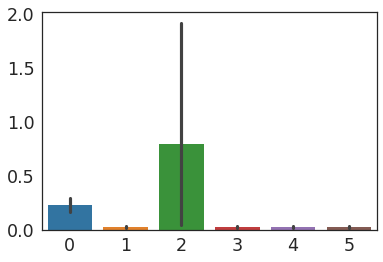

In [10]:
sns.barplot(data=error)